# Taxi Orders Time Series Prediction

# Business Problem

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, they need to predict the amount of taxi orders for the next hour. To do this they need an accurate machine learning model for such a prediction.

The RMSE metric on the test set should not be more than 48.

**Solution Steps:**

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Create new features useful in model training.
4. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
5. Test the data using the test sample.
6. Select the model with the best performance on the test dataset.

# Data description

The data is stored in file `taxi.csv`. The data contains time series data from 2018 in the form of the number of taxi cab orders received every 10 minutes. The number of orders is in the '*num_orders*' column.

## Preparation

**Importing Libraries**
- In addition to the standard libraries, I import the ML models I will use: LinearRegression, RandomForestRegressor, GradientBoostingRegressor, and AutoReg

In [63]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [64]:
warnings.simplefilter(action='ignore', category=FutureWarning)

**Loading File as DataFrame**
- I pass 'parse_dates' and 'index_col' to convert the date column to datetime64 and set it as the index.
- I ensure the index (dates) are sorted by calling 'sort_index.'

In [65]:
try:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except FileNotFoundError:
    df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

**DataFrame Inspection**
- Data is divided into equal intervals of 10 minutes.

In [66]:
df.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


**Resample Data**
- Data from the 'num_orders' column is resampled from 10 minute intervals to 1 hour intervals. The sum of each 10 minute interval is added for the total number of orders per hour.

In [67]:
df.sort_index(inplace=True)
df = df.resample('1H').sum()

In [68]:
df.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


**Checking for Missing Values**
- Duplicated values are to be expected given that some hours may have the same number of orders as other hours.

In [69]:
df.isna().sum()

num_orders    0
dtype: int64

**Checking for Duplicated Rows**

In [70]:
df.duplicated().sum()

4165

## Exploratory Analysis

**Descriptive Statistics:**

In [71]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


- The mean orders per hour is about 84, the median is slightly below at about 78 orders per hour. 
- The time range of the data spans from 2018-03-01 to 2018-08-31, providing 6 months of taxi order data.

In [72]:
print('Start date: ', df.index[0])
print('End date: ', df.index[-1])

Start date:  2018-03-01 00:00:00
End date:  2018-08-31 23:00:00


**Visualizing the Series:**

<Axes: xlabel='datetime'>

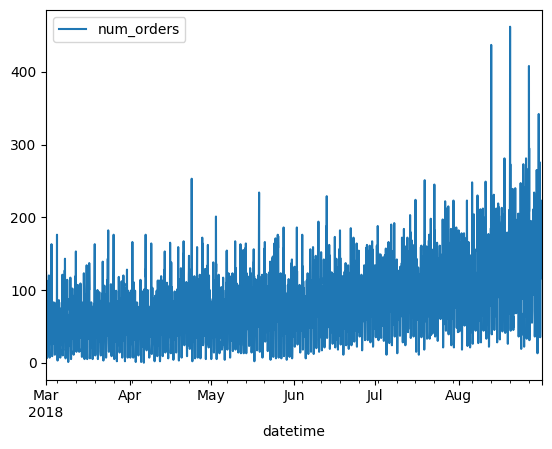

In [73]:
df.plot()

In [74]:
stationary_test = adfuller(df, autolag='AIC')
print('p_value: ', stationary_test[1])

p_value:  0.0289400514026128


<Axes: xlabel='datetime'>

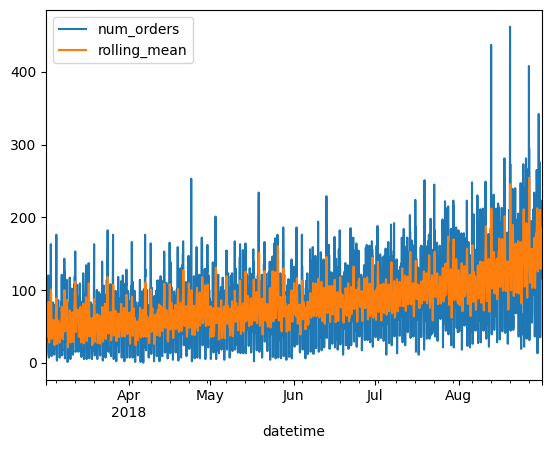

In [75]:
df['rolling_mean'] = df.rolling(7).mean()
df.dropna(inplace=True)
df.plot()

- Upon visual inspection, the series appears to be mostly stationary since the mean remains fairly constant. Using the adfuller test and receiving a p-value less than 0.05 confirms this. Since the series is stationary, there is no need to take the difference.
- Plotting the original data with the rolling mean supports the result of the adfuller test. The mean remains relatively stable through the series.

**Trend and Seasonality:**

In [76]:
df = df.drop('rolling_mean',axis=1)

In [77]:
decomposed = seasonal_decompose(df['2018-05-01':'2018-05-31'])

Text(0.5, 1.0, 'Residuals')

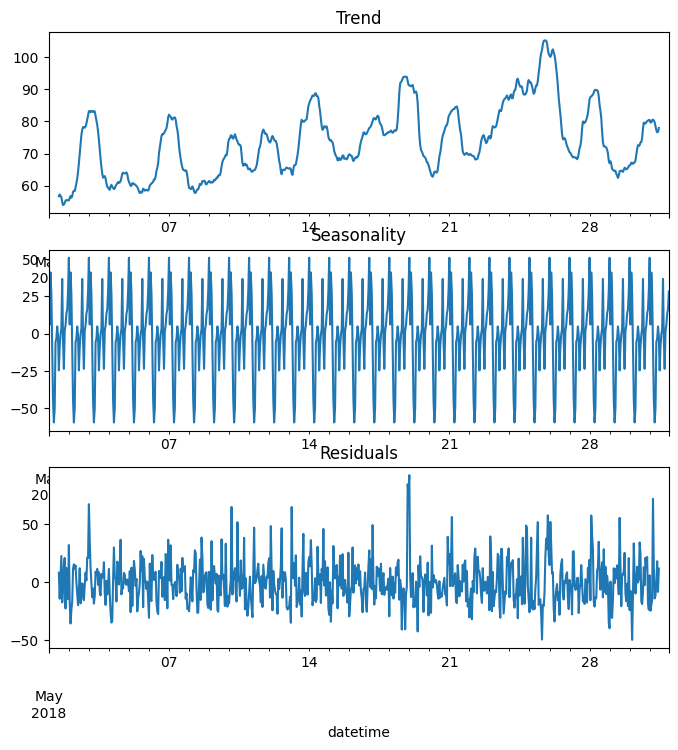

In [78]:
plt.figure(figsize=(8, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

- To study the series in more detail, only 1 month is included in the data slice for 'seasonal_decompose'.
- As would be expected, there is a daily seasonal cycle of orders (orders for taxi service are highest at the busiest times of day.
- Each week there are 2-3 'humps' of upward/downward trends.

## Feature Engineering:

- The following features are created for model training: month, day, day of week, hour, 7 lag columns, and a rolling mean column with a window of 7. 
- NaNs from the lag and rolling mean columns features are dropped.

In [79]:
def features(df, max_lag, rolling_mean_size):
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    for i in range(1, max_lag + 1):
        df['lag_{}'.format(i)] = df['num_orders'].shift(i)
    
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

features(df, 7, 7)

In [80]:
df.head(10)

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean
datetime,,,,,,,,,,,,,
2018-03-01 06:00:00,12,3,1,3,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 07:00:00,15,3,1,3,7,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 08:00:00,34,3,1,3,8,15.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 09:00:00,69,3,1,3,9,34.0,15.0,12.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 10:00:00,64,3,1,3,10,69.0,34.0,15.0,12.0,NaN,NaN,NaN,NaN
2018-03-01 11:00:00,96,3,1,3,11,64.0,69.0,34.0,15.0,12.0,NaN,NaN,NaN
2018-03-01 12:00:00,30,3,1,3,12,96.0,64.0,69.0,34.0,15.0,12.0,NaN,NaN
2018-03-01 13:00:00,32,3,1,3,13,30.0,96.0,64.0,69.0,34.0,15.0,12.0,45.714286
2018-03-01 14:00:00,48,3,1,3,14,32.0,30.0,96.0,64.0,69.0,34.0,15.0,48.571429


**Dropping NaN Values:**

In [81]:
df.dropna(inplace=True)

## Machine Learning Modeling

**Train/Test Split**
- The features created above are saved to a feature matrix, X.
- The target, 'num_orders' is saved to y.
- The test dataset is set to be 10% of the original dataset.
- The shuffle parameter is disabled to keep the data in chronological order.

In [82]:
X = df.drop('num_orders', axis=1)
y = df['num_orders']

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

**Sanity Check/Dummy Model**
- To serve as a baseline for trained models (and evaluate if training has actually taken place in models) I use the median value of the training set as the predictions of the test values. 

In [84]:
print('Median hourly orders: ', y_train.median())

Median hourly orders:  75.0


In [85]:
pred_median = np.ones(y_test.shape) * y_train.median()
rmse_med = mean_squared_error(y_test, pred_median) ** 0.5
print('RMSE: ', rmse_med)

RMSE:  87.24205906985632


C:\Users\lette\AppData\Local\Temp\ipykernel_7680\2907393670.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


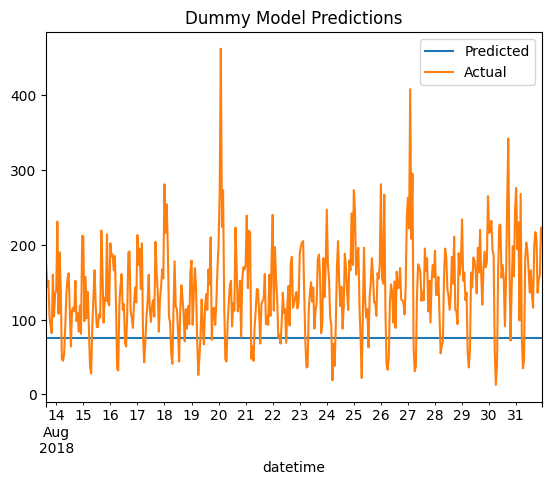

In [86]:
pred = pd.Series(pred_median, index=y_test.index)

fig, ax = plt.subplots()
pred.plot()
y_test.plot()
ax.legend(['Predicted','Actual'])
ax.set_title('Dummy Model Predictions')
fig.show()

**Linear Regression Model**
- Each model's train and test predictions are evaluated using RMSE.

In [87]:
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

pred_train = lin_model.predict(X_train)
pred_test_lin_model = lin_model.predict(X_test)

In [88]:
rmse_lin = mean_squared_error(y_test, pred_test_lin_model) ** 0.5

In [89]:
print('RMSE for train: ', mean_squared_error(y_train, pred_train) ** 0.5)
print('RMSE for test: ', rmse_lin)

RMSE for train:  30.42596825157389
RMSE for test:  52.73330971844558


C:\Users\lette\AppData\Local\Temp\ipykernel_7680\2065521898.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


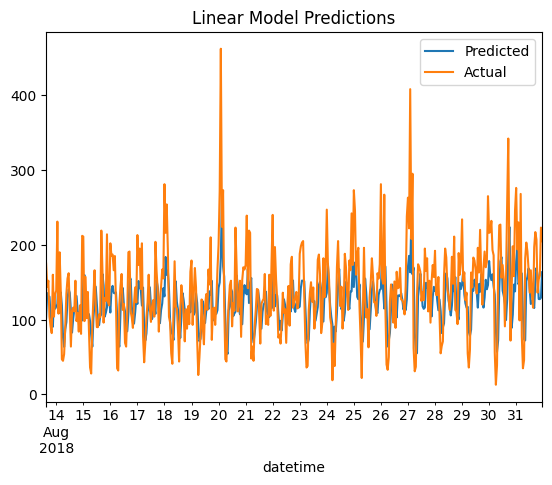

In [90]:
pred = pd.Series(pred_test_lin_model, index=y_test.index)

fig, ax = plt.subplots()
pred.plot()
y_test.plot()
ax.legend(['Predicted','Actual'])
ax.set_title('Linear Model Predictions')
fig.show()

**Random Forest**
- The hyperparamters of this model are tuned using GridSearchCV.
- The best performing model has 'max_depth' of 8 and 120 estimators.

In [91]:
forest_model = RandomForestRegressor(random_state=12345)

params = {'n_estimators':[80, 100, 120], 'max_depth':[2, 5, 8]}
grid = GridSearchCV(forest_model, params)
grid.fit(X_train, y_train)

forest_model = grid.best_estimator_
print('Best model params: ', grid.best_params_)

Best model params:  {'max_depth': 8, 'n_estimators': 120}


In [92]:
pred_train = lin_model.predict(X_train)
pred_test_forest_model = lin_model.predict(X_test)

In [93]:
rmse_forest = mean_squared_error(y_test, pred_test_forest_model) ** 0.5

In [94]:
print('RMSE for train: ', mean_squared_error(y_train, pred_train) ** 0.5)
print('RMSE for test: ', rmse_forest)

RMSE for train:  30.42596825157389
RMSE for test:  52.73330971844558


C:\Users\lette\AppData\Local\Temp\ipykernel_7680\4059806153.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


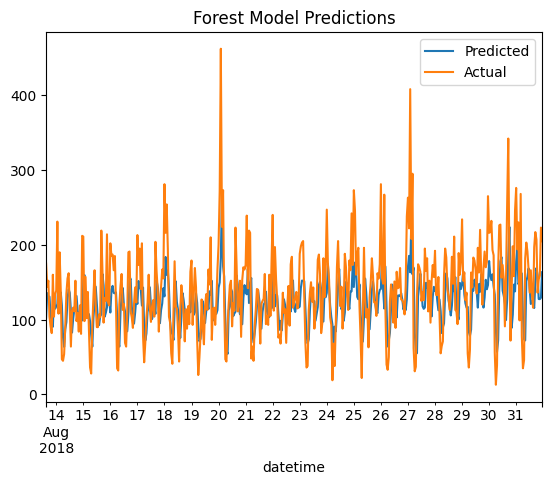

In [95]:
pred = pd.Series(pred_test_forest_model, index=y_test.index)

fig, ax = plt.subplots()
pred.plot()
y_test.plot()
ax.legend(['Predicted','Actual'])
ax.set_title('Forest Model Predictions')
fig.show()

**Gradient Boosting Regressor**
- Similarly to the RandomForestRegressor, this model uses GridSearchCV for hyperparamter tuning.
- The best model has a 'max depth' of 5 and 80 estimators.

In [96]:
gb_model = GradientBoostingRegressor(random_state=12345)

params = {'n_estimators':[80, 100, 120], 'max_depth':[5, 10, 15]}
grid = GridSearchCV(gb_model, params)
grid.fit(X_train, y_train)

gb_model = grid.best_estimator_
print('Best model params: ', grid.best_params_)

Best model params:  {'max_depth': 5, 'n_estimators': 100}


In [97]:
pred_train = gb_model.predict(X_train)
pred_test_gb_model = gb_model.predict(X_test)

rmse_gb = mean_squared_error(y_test, pred_test_gb_model) ** 0.5

print('RMSE GB Model Train: ', mean_squared_error(y_train, pred_train) ** 0.5)
print('RMSE GB Model Test: ', rmse_gb)

RMSE GB Model Train:  15.086568468951414
RMSE GB Model Test:  44.12760349466151


C:\Users\lette\AppData\Local\Temp\ipykernel_7680\675088743.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


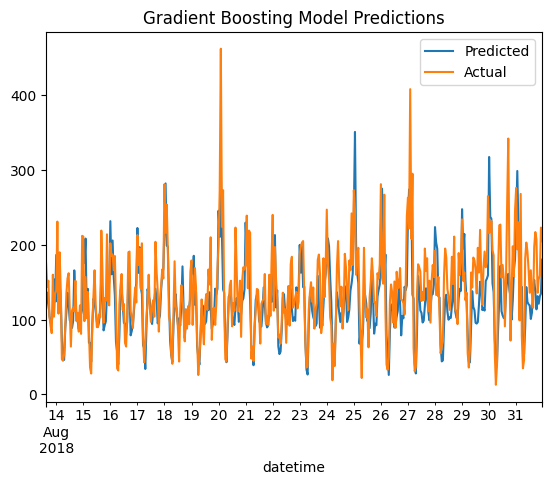

In [98]:
pred = pd.Series(pred_test_gb_model, index=y_test.index)

fig, ax = plt.subplots()
pred.plot()
y_test.plot()
ax.legend(['Predicted','Actual'])
ax.set_title('Gradient Boosting Model Predictions')
fig.show()

**Autoregressive Model**
- Before model training, the method 'ar_select_order' is called to determine the optimal number of lags.

In [99]:
df = df.iloc[:,0]
train, test = train_test_split(df, test_size=0.1, shuffle=False)

In [100]:
mod = ar_select_order(endog=train, maxlag=40)
ar_order = mod.ar_lags
print('Number of lags defining order: ', ar_order)

Number of lags defining order:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]


In [101]:
ar_model = AutoReg(train, lags=ar_order).fit()

start_val = len(train)
end_val = len(train) + len(test) - 1

ar_pred_ar_model = ar_model.model.predict(ar_model.params, start=start_val, end=end_val, dynamic=False)
rmse_ar = mean_squared_error(test, ar_pred_ar_model) ** 0.5

print('RMSE of AutoRegressive Model: ', rmse_ar)

RMSE of AutoRegressive Model:  74.85353801440668


C:\Users\lette\AppData\Local\Temp\ipykernel_7680\1618117033.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


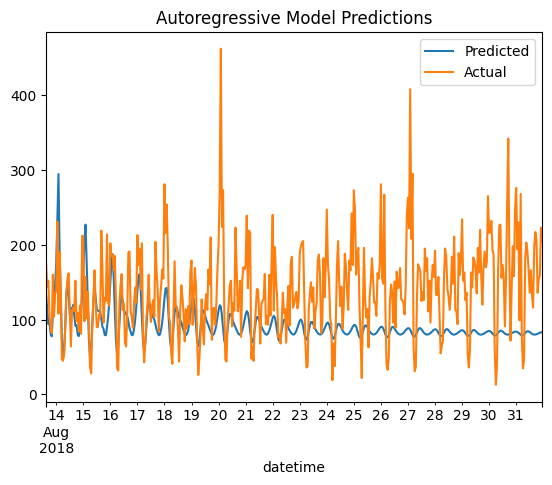

In [102]:
pred = pd.Series(ar_pred_ar_model, index=y_test.index)

fig, ax = plt.subplots()
pred.plot()
y_test.plot()
ax.legend(['Predicted','Actual'])
ax.set_title('Autoregressive Model Predictions')
fig.show()

## Model Testing

**Test RMSE of Models**
- The GradientBoostingRegressor performed best, receiving the lowest RMSE score. It outperformed the Median 'dummy model' by a large margin.
- Of the trained models, the AR model performed most poorly. The LinearRegression and Random Forest models are about equal in their performance but Linear Regression is significantly faster to train.

In [103]:
print('Linear Model Test RMSE: {:.3f}'.format(rmse_lin))
print('Random Forest Model Test RMSE: {:.3f}'.format(rmse_forest))
print('Gradient Boosting Model Test RMSE: {:.3f}'.format(rmse_gb))
print('AR Model Test RMSE: {:.3f}'.format(rmse_ar))
print('Median RMSE: {:.3f}'.format(rmse_med))

Linear Model Test RMSE: 52.733
Random Forest Model Test RMSE: 52.733
Gradient Boosting Model Test RMSE: 44.128
AR Model Test RMSE: 74.854
Median RMSE: 87.242


## Model Selection
- The Gradient Boosting model received an RMSE score less than 48 and provided the best quality in forecasting the target 'num_orders'. For this reason, I recommend that this model be used for hourly taxi cab order predictions.